🚀 Enhanced Home Insurance Lead Prediction Model

📊 DATASET OVERVIEW
------------------------------
Dataset shape: (10000, 8)
Conversion rate: 24.67%
Missing values: 0

🔍 FIRST 5 ROWS:
   lead_id  house_age  house_value  occupation  income  prior_claims  \
0     1001         19       140000  Technician   59308             0   
1     1002         22       180000     Analyst   76127             0   
2     1003          2       465000      Doctor  152502             0   
3     1004         11       155000  Technician   60611             0   
4     1005          8       220000     Manager   85312             0   

   credit_score  converted  
0           690          1  
1           640          0  
2           780          1  
3           630          0  
4           690          1  

📈 STATISTICAL SUMMARY:
           lead_id   house_age    house_value         income  prior_claims  \
count  10000.00000  10000.0000   10000.000000   10000.000000  10000.000000   
mean    6000.50000     15.402

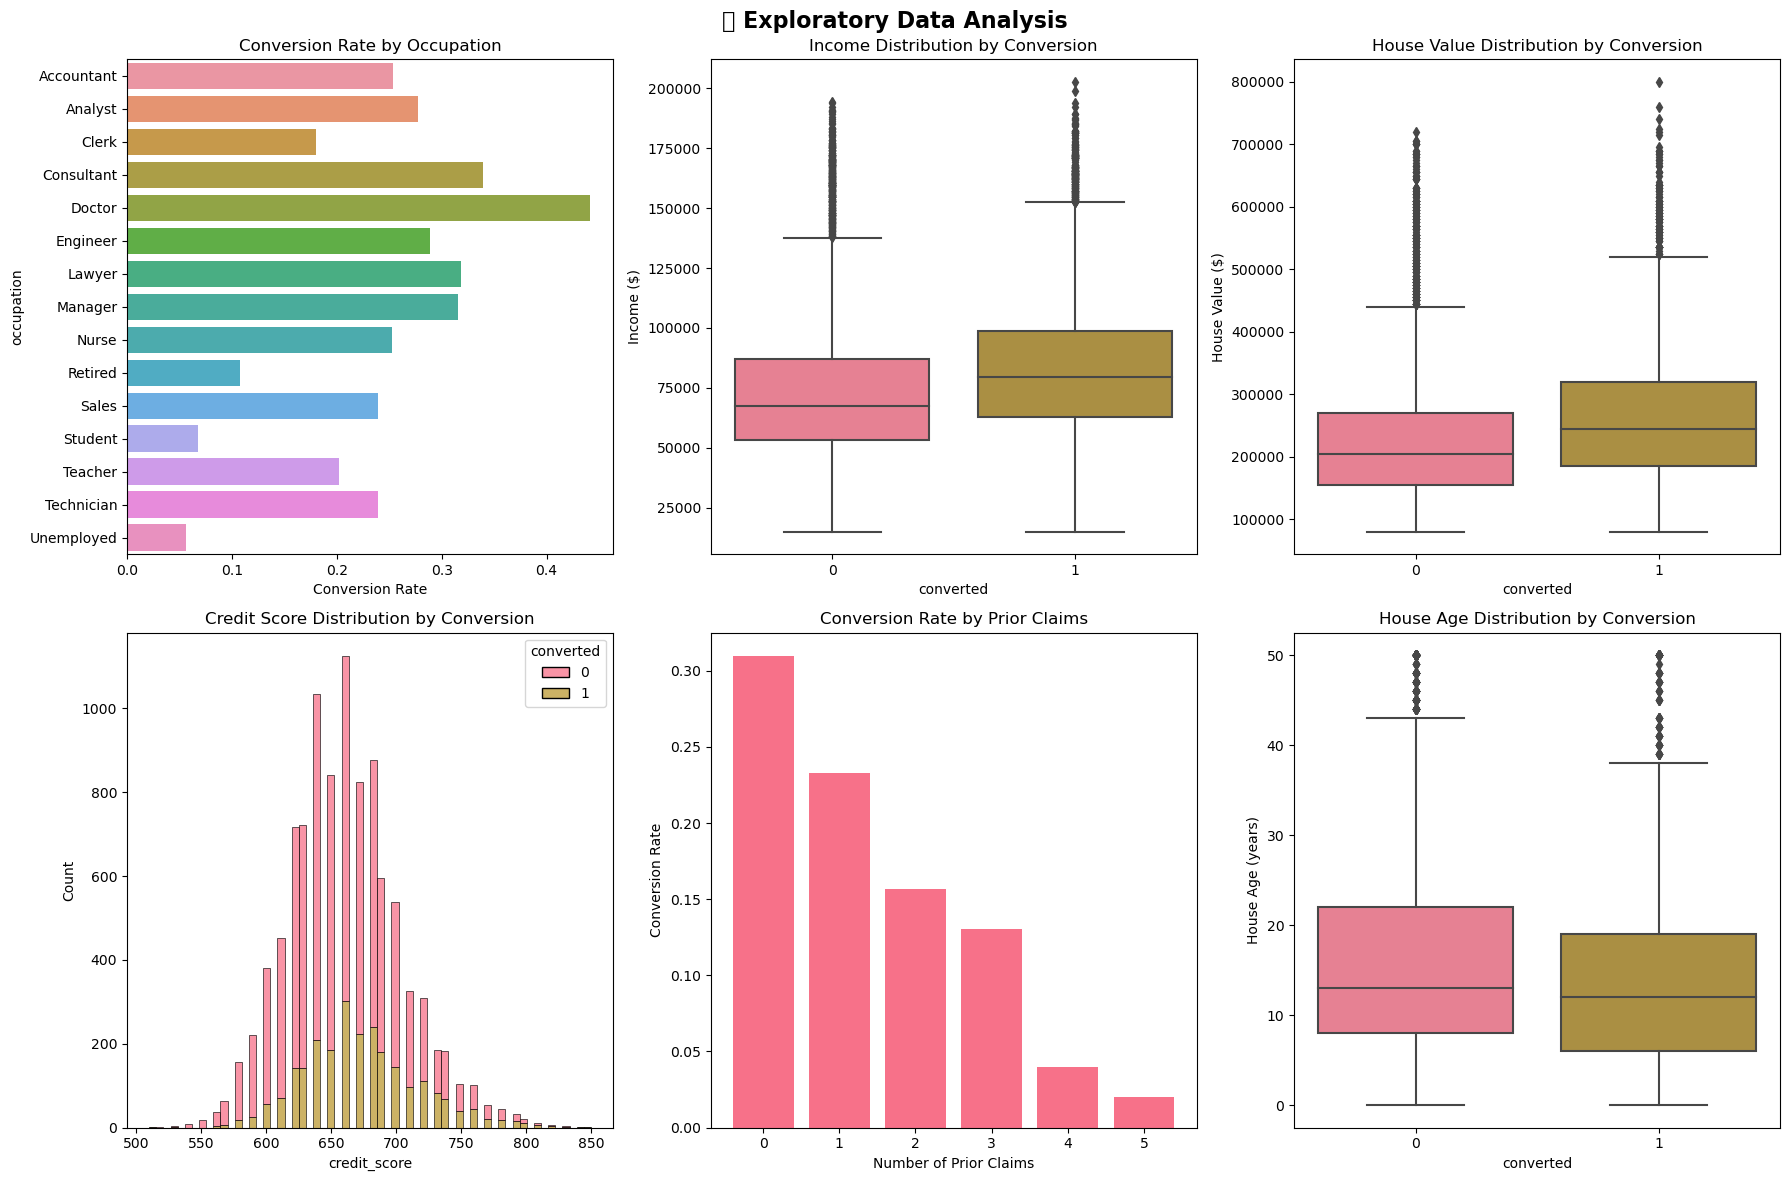


🔧 FEATURE ENGINEERING
------------------------------
✅ Created new features:
   • occ_conversion_rate
   • occ_frequency
   • occ_avg_income
   • income_bracket
   • income_per_house_value
   • house_value_bracket
   • house_age_bracket
   • high_risk
   • premium_customer
   • credit_category

⚙️ ADVANCED PREPROCESSING
------------------------------
✅ Final feature set: 16 features
   • Numerical features: 16
✅ Train set: 7000 samples
✅ Test set: 3000 samples

🤖 ENHANCED MODEL TRAINING
------------------------------

🔄 Training Logistic Regression...
   ✅ Best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
   📊 Train AUC: 0.6911
   📊 Test AUC: 0.6834

🔄 Training Random Forest...
   ✅ Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
   📊 Train AUC: 0.8964
   📊 Test AUC: 0.6673

🔄 Training Gradient Boosting...
   ✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
   📊 Train AUC: 0.7263
 

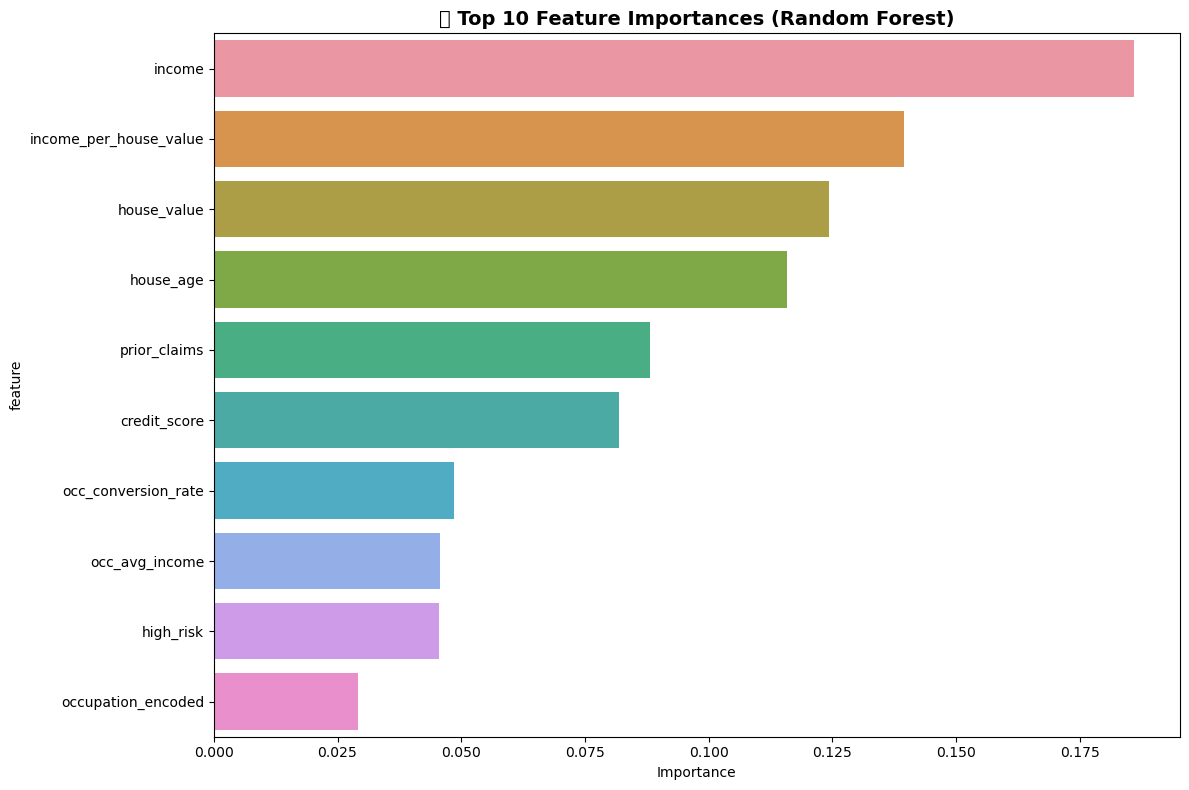


📊 GENERATING MODEL EVALUATION PLOTS...


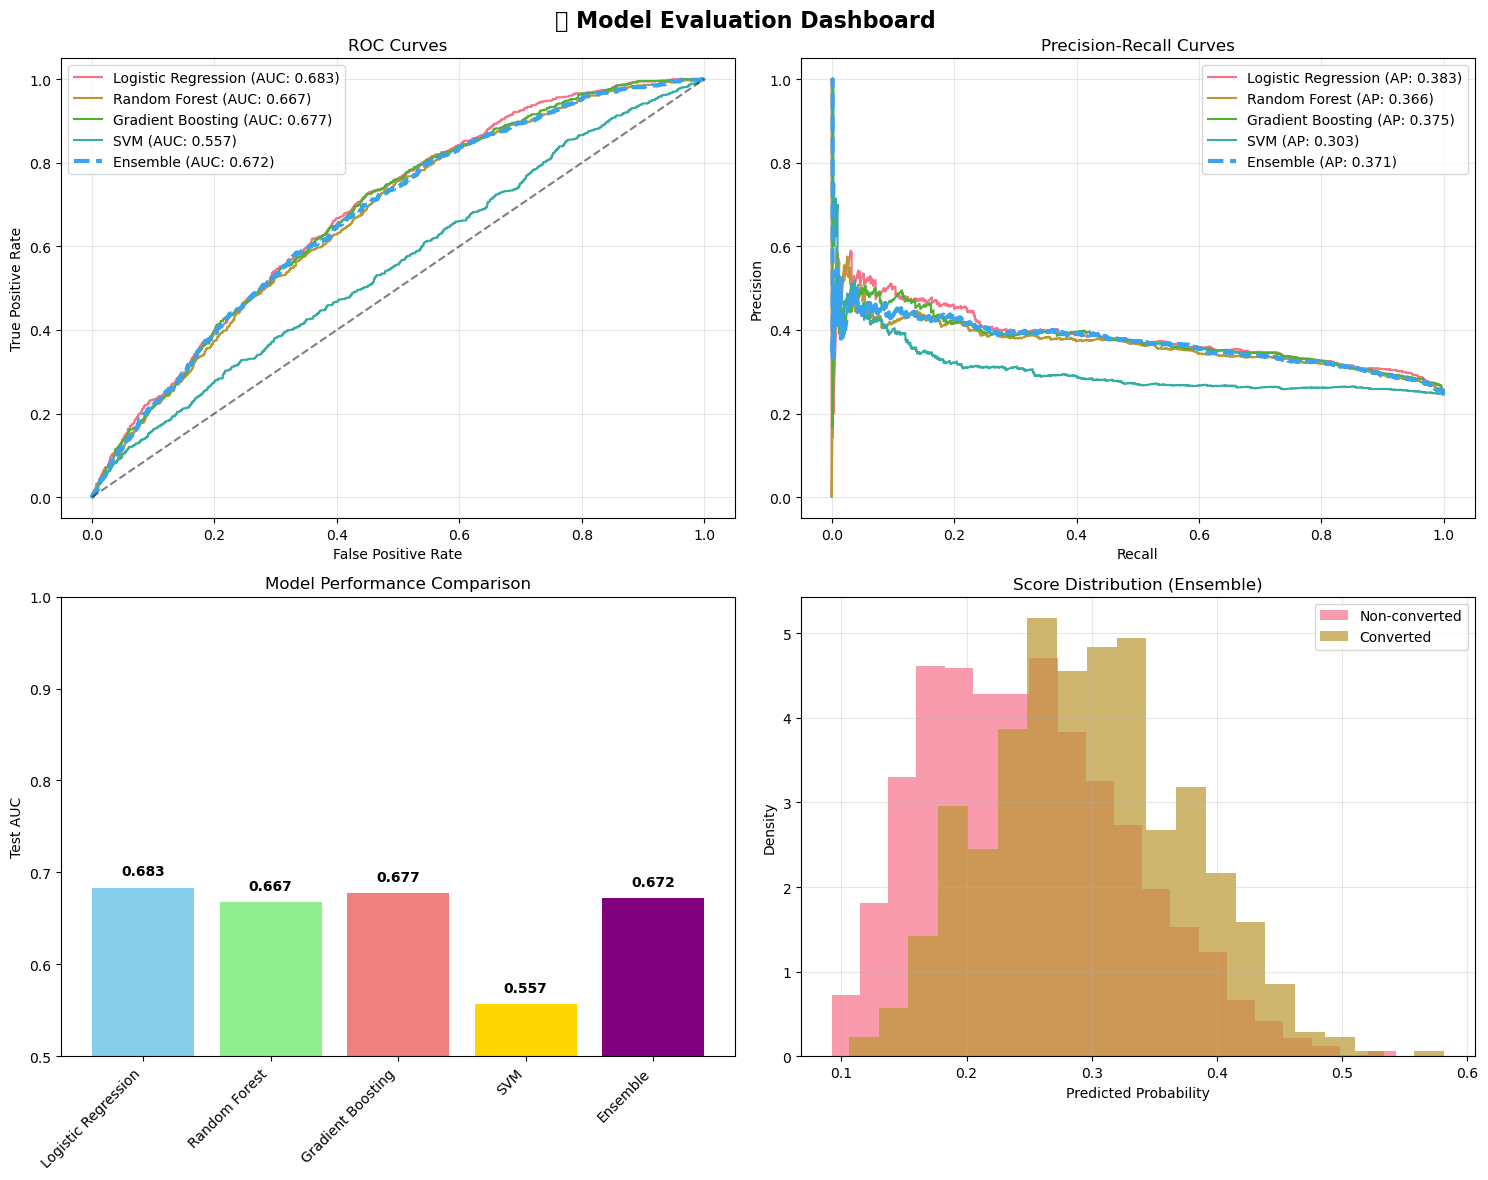


💼 LEAD SCORING AND BUSINESS INSIGHTS
------------------------------
📊 LEAD SEGMENT ANALYSIS:
              Total_Leads  Conversions  Conv_Rate  Min_Score  Max_Score  \
lead_segment                                                              
Cold                 6906         1007      0.146      0.092      0.300   
Warm                 3094         1460      0.472      0.300      0.597   
Hot                     0            0        NaN        NaN        NaN   
Very Hot                0            0        NaN        NaN        NaN   

              Avg_Score  Avg_Income  Avg_House_Value  
lead_segment                                          
Cold              0.214   64466.682       194194.179  
Warm              0.360  100256.903       319503.878  
Hot                 NaN         NaN              NaN  
Very Hot            NaN         NaN              NaN  

🎯 TOP 10 SCORING LEADS:
      lead_id  lead_score  converted  occupation  income  house_value  \
1025     2026    0.597077  

In [8]:
# Home Insurance Lead Prediction Model
# ============================================================================

# --- 1. Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix, 
                            roc_curve, precision_recall_curve, average_precision_score)
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
#plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Enhanced Home Insurance Lead Prediction Model")
print("=" * 60)

# --- 2. Load and Explore Data ---
df = pd.read_csv("insurance_leads_data_20250907_171047.csv")

print("\n📊 DATASET OVERVIEW")
print("-" * 30)
print(f"Dataset shape: {df.shape}")
print(f"Conversion rate: {df['converted'].mean():.2%}")
print(f"Missing values: {df.isnull().sum().sum()}")

print("\n🔍 FIRST 5 ROWS:")
print(df.head())

print("\n📈 STATISTICAL SUMMARY:")
print(df.describe())

print("\n🏢 OCCUPATION DISTRIBUTION:")
print(df['occupation'].value_counts())

# --- 3. Exploratory Data Analysis ---
def plot_eda():
    """Comprehensive exploratory data analysis"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 Exploratory Data Analysis', fontsize=16, fontweight='bold')
    
    # Conversion rate by occupation
    conversion_by_occ = df.groupby('occupation')['converted'].agg(['mean', 'count']).reset_index()
    conversion_by_occ = conversion_by_occ[conversion_by_occ['count'] >= 50]  # Filter low counts
    sns.barplot(data=conversion_by_occ, x='mean', y='occupation', ax=axes[0,0])
    axes[0,0].set_title('Conversion Rate by Occupation')
    axes[0,0].set_xlabel('Conversion Rate')
    
    # Income distribution by conversion
    sns.boxplot(data=df, x='converted', y='income', ax=axes[0,1])
    axes[0,1].set_title('Income Distribution by Conversion')
    axes[0,1].set_ylabel('Income ($)')
    
    # House value vs conversion
    sns.boxplot(data=df, x='converted', y='house_value', ax=axes[0,2])
    axes[0,2].set_title('House Value Distribution by Conversion')
    axes[0,2].set_ylabel('House Value ($)')
    
    # Credit score distribution
    sns.histplot(data=df, x='credit_score', hue='converted', multiple="stack", ax=axes[1,0])
    axes[1,0].set_title('Credit Score Distribution by Conversion')
    
    # Prior claims impact
    prior_claims_conv = df.groupby('prior_claims')['converted'].mean()
    axes[1,1].bar(prior_claims_conv.index, prior_claims_conv.values)
    axes[1,1].set_title('Conversion Rate by Prior Claims')
    axes[1,1].set_xlabel('Number of Prior Claims')
    axes[1,1].set_ylabel('Conversion Rate')
    
    # House age vs conversion
    sns.boxplot(data=df, x='converted', y='house_age', ax=axes[1,2])
    axes[1,2].set_title('House Age Distribution by Conversion')
    axes[1,2].set_ylabel('House Age (years)')
    
    plt.tight_layout()
    plt.show()

print("\n🎨 GENERATING EXPLORATORY DATA ANALYSIS...")
plot_eda()

# --- 4. Feature Engineering ---
print("\n🔧 FEATURE ENGINEERING")
print("-" * 30)

# Create a copy for feature engineering
df_eng = df.copy()

# Encode occupation with frequency and conversion rate
occupation_stats = df.groupby('occupation').agg({
    'converted': ['mean', 'count'],
    'income': 'mean'
}).round(4)
occupation_stats.columns = ['occ_conversion_rate', 'occ_frequency', 'occ_avg_income']
df_eng = df_eng.merge(occupation_stats, left_on='occupation', right_index=True)

# Income-based features
df_eng['income_bracket'] = pd.cut(df_eng['income'], bins=[0, 40000, 70000, 100000, np.inf], 
                                 labels=['Low', 'Medium', 'High', 'Very High'])
df_eng['income_per_house_value'] = df_eng['income'] / df_eng['house_value']

# House-related features
df_eng['house_value_bracket'] = pd.cut(df_eng['house_value'], 
                                      bins=[0, 150000, 250000, 350000, np.inf],
                                      labels=['Low', 'Medium', 'High', 'Luxury'])
df_eng['house_age_bracket'] = pd.cut(df_eng['house_age'], 
                                    bins=[0, 10, 25, 40, np.inf],
                                    labels=['New', 'Recent', 'Mature', 'Old'])

# Risk-based features
df_eng['high_risk'] = ((df_eng['prior_claims'] >= 2) | (df_eng['credit_score'] < 650)).astype(int)
df_eng['premium_customer'] = ((df_eng['income'] > 100000) & (df_eng['credit_score'] > 750)).astype(int)

# Credit score categories
df_eng['credit_category'] = pd.cut(df_eng['credit_score'], 
                                  bins=[0, 600, 700, 750, 850],
                                  labels=['Poor', 'Fair', 'Good', 'Excellent'])

print("✅ Created new features:")
new_features = ['occ_conversion_rate', 'occ_frequency', 'occ_avg_income', 'income_bracket', 
               'income_per_house_value', 'house_value_bracket', 'house_age_bracket', 
               'high_risk', 'premium_customer', 'credit_category']
for feat in new_features:
    print(f"   • {feat}")

# --- 5. Advanced Preprocessing ---
print("\n⚙️ ADVANCED PREPROCESSING")
print("-" * 30)

# Encode all categorical variables
categorical_features = ['occupation', 'income_bracket', 'house_value_bracket', 
                       'house_age_bracket', 'credit_category']

le_dict = {}
for col in categorical_features:
    le_dict[col] = LabelEncoder()
    df_eng[f'{col}_encoded'] = le_dict[col].fit_transform(df_eng[col])

# Select features for modeling
feature_columns = ['house_age', 'house_value', 'income', 'prior_claims', 'credit_score',
                  'occ_conversion_rate', 'occ_frequency', 'occ_avg_income',
                  'income_per_house_value', 'high_risk', 'premium_customer',
                  'occupation_encoded', 'income_bracket_encoded', 
                  'house_value_bracket_encoded', 'house_age_bracket_encoded',
                  'credit_category_encoded']

X = df_eng[feature_columns]
y = df_eng['converted']

print(f"✅ Final feature set: {X.shape[1]} features")
print(f"   • Numerical features: {X.select_dtypes(include=[np.number]).shape[1]}")

# --- 6. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"✅ Train set: {X_train.shape[0]} samples")
print(f"✅ Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Enhanced Model Training with Hyperparameter Tuning ---
print("\n🤖 ENHANCED MODEL TRAINING")
print("-" * 30)

# Define models with hyperparameter grids
models_config = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        },
        "use_scaled": True
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        "use_scaled": False
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        },
        "use_scaled": False
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        },
        "use_scaled": True
    }
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and tune models
best_models = {}
model_results = {}

for name, config in models_config.items():
    print(f"\n🔄 Training {name}...")
    
    # Choose scaled or unscaled data
    X_train_model = X_train_scaled if config["use_scaled"] else X_train
    X_test_model = X_test_scaled if config["use_scaled"] else X_test
    
    # Grid search
    grid_search = GridSearchCV(
        config["model"], 
        config["params"], 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_model, y_train)
    
    # Best model
    best_models[name] = grid_search.best_estimator_
    
    # Predictions
    train_proba = grid_search.predict_proba(X_train_model)[:, 1]
    test_proba = grid_search.predict_proba(X_test_model)[:, 1]
    
    # Metrics
    train_auc = roc_auc_score(y_train, train_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    
    model_results[name] = {
        'train_auc': train_auc,
        'test_auc': test_auc,
        'best_params': grid_search.best_params_,
        'test_proba': test_proba
    }
    
    print(f"   ✅ Best params: {grid_search.best_params_}")
    print(f"   📊 Train AUC: {train_auc:.4f}")
    print(f"   📊 Test AUC: {test_auc:.4f}")

# --- 8. Model Comparison and Ensemble ---
print("\n🏆 MODEL COMPARISON")
print("-" * 30)

results_df = pd.DataFrame({
    name: [results['train_auc'], results['test_auc']] 
    for name, results in model_results.items()
}, index=['Train AUC', 'Test AUC'])

print(results_df.round(4))

# Create ensemble
print("\n🎭 CREATING ENSEMBLE MODEL")
ensemble_models = [
    ('rf', best_models['Random Forest']),
    ('gb', best_models['Gradient Boosting']),
    ('lr', best_models['Logistic Regression'])
]

ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')
ensemble.fit(X_train, y_train)

ensemble_proba = ensemble.predict_proba(X_test)[:, 1]
ensemble_auc = roc_auc_score(y_test, ensemble_proba)

print(f"🎯 Ensemble AUC: {ensemble_auc:.4f}")

# --- 9. Feature Importance Analysis ---
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("-" * 30)

# Get feature importance from Random Forest
rf_model = best_models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('🔍 Top 10 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# --- 10. Model Evaluation Visualization ---
def plot_model_evaluation():
    """Comprehensive model evaluation plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🎯 Model Evaluation Dashboard', fontsize=16, fontweight='bold')
    
    # ROC Curves
    ax = axes[0, 0]
    for name, results in model_results.items():
        fpr, tpr, _ = roc_curve(y_test, results['test_proba'])
        ax.plot(fpr, tpr, label=f"{name} (AUC: {results['test_auc']:.3f})")
    
    # Ensemble ROC
    fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_proba)
    ax.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC: {ensemble_auc:.3f})", 
            linewidth=3, linestyle='--')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Precision-Recall Curves
    ax = axes[0, 1]
    for name, results in model_results.items():
        precision, recall, _ = precision_recall_curve(y_test, results['test_proba'])
        ap_score = average_precision_score(y_test, results['test_proba'])
        ax.plot(recall, precision, label=f"{name} (AP: {ap_score:.3f})")
    
    # Ensemble PR
    precision_ens, recall_ens, _ = precision_recall_curve(y_test, ensemble_proba)
    ap_score_ens = average_precision_score(y_test, ensemble_proba)
    ax.plot(recall_ens, precision_ens, label=f"Ensemble (AP: {ap_score_ens:.3f})", 
            linewidth=3, linestyle='--')
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Model Performance Comparison
    ax = axes[1, 0]
    model_names = list(model_results.keys()) + ['Ensemble']
    test_aucs = [model_results[name]['test_auc'] for name in model_results.keys()] + [ensemble_auc]
    
    bars = ax.bar(model_names, test_aucs, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'purple'])
    ax.set_ylabel('Test AUC')
    ax.set_title('Model Performance Comparison')
    ax.set_ylim(0.5, 1.0)
    
    # Add value labels on bars
    for bar, auc in zip(bars, test_aucs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Score Distribution
    ax = axes[1, 1]
    ax.hist(ensemble_proba[y_test == 0], bins=20, alpha=0.7, label='Non-converted', density=True)
    ax.hist(ensemble_proba[y_test == 1], bins=20, alpha=0.7, label='Converted', density=True)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.set_title('Score Distribution (Ensemble)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n📊 GENERATING MODEL EVALUATION PLOTS...")
plot_model_evaluation()

# --- 11. Lead Scoring and Business Insights ---
print("\n💼 LEAD SCORING AND BUSINESS INSIGHTS")
print("-" * 30)

# Score all leads using ensemble
df_eng['lead_score'] = ensemble.predict_proba(X)[:, 1]

# Create lead segments
df_eng['lead_segment'] = pd.cut(df_eng['lead_score'], 
                               bins=[0, 0.3, 0.6, 0.8, 1.0],
                               labels=['Cold', 'Warm', 'Hot', 'Very Hot'])

# Segment analysis
segment_analysis = df_eng.groupby('lead_segment').agg({
    'converted': ['count', 'sum', 'mean'],
    'lead_score': ['min', 'max', 'mean'],
    'income': 'mean',
    'house_value': 'mean'
}).round(3)

segment_analysis.columns = ['Total_Leads', 'Conversions', 'Conv_Rate', 
                          'Min_Score', 'Max_Score', 'Avg_Score',
                          'Avg_Income', 'Avg_House_Value']

print("📊 LEAD SEGMENT ANALYSIS:")
print(segment_analysis)

# Top scoring leads
print("\n🎯 TOP 10 SCORING LEADS:")
top_leads = df_eng.nlargest(10, 'lead_score')[['lead_id', 'lead_score', 'converted', 
                                             'occupation', 'income', 'house_value', 
                                             'credit_score', 'lead_segment']]
print(top_leads)

# Business recommendations
print("\n💡 BUSINESS RECOMMENDATIONS")
print("-" * 30)
warm = len(df_eng[df_eng['lead_segment'] == 'Warm'])
very_hot_leads = len(df_eng[df_eng['lead_segment'] == 'Very Hot'])
hot_leads = len(df_eng[df_eng['lead_segment'] == 'Hot'])
total_high_value = very_hot_leads + hot_leads + warm

print(f"🔥 Focus on {very_hot_leads:,} 'Very Hot' leads (conversion rate: {df_eng[df_eng['lead_segment'] == 'Very Hot']['converted'].mean():.1%})")
print(f"🔥 Follow up with {hot_leads:,} 'Hot' leads (conversion rate: {df_eng[df_eng['lead_segment'] == 'Hot']['converted'].mean():.1%})")
print(f"🎯 Total high-priority leads: {total_high_value:,} ({total_high_value/len(df_eng):.1%} of all leads)")

# Expected conversion improvement
current_conversion = df_eng['converted'].mean()
high_priority_conversion = df_eng[df_eng['lead_segment'].isin(['Hot', 'Very Hot'])]['converted'].mean()
improvement = (high_priority_conversion - current_conversion) / current_conversion * 100

print(f"📈 Expected conversion improvement by focusing on high-priority leads: +{improvement:.1f}%")

# --- 12. Final Model Export ---
print(f"\n💾 MODEL READY FOR DEPLOYMENT")
print(f"   🎯 Best model: Ensemble (AUC: {ensemble_auc:.4f})")
print(f"   🔧 Features used: {len(feature_columns)}")
print(f"   📊 Lead segments created: 4 (Cold, Warm, Hot, Very Hot)")
print(f"   🎯 High-priority leads identified: {total_high_value:,}")

print("\n✅ ANALYSIS COMPLETE!")
print("=" * 60)